# Homework 02
## Goal
Represent digits '3' in 2D.  
* convert data from the UCI [Optical Recognition of Handwritten Digits Data Set](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)
* perform PCA over all digit '3' with 2 components
* plot the PCA results as below (also in page #12 of PCA )
## Requirements
* Programming lanuage: python3
* Optional package: tensorflow web or pytorch
* Plot the results in matplotlib Introduction in Chinese Tutorial

## PCA
We use pytorch 1.13 package for this homework, please download the following requirements:

In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Convert data from the original dataset and represent digits '3' in 2D,

In [2]:
def read_ori_data(file):
    dataset = []
    f = open(file, encoding='utf-8')
    for i in range(21):
        f.readline()
    while True:
        s = f.readline().strip()
        if not s:
            break
        for i in range(31):
            s += f.readline().strip()
        label = int(f.readline().strip())
        dataset.append((torch.tensor(list(map(int, s))), label))
    return dataset

def get_data_with_label(dataset, label):
    three = []

    for i in dataset:
        if i[1] == label:
            three.append(torch.unsqueeze(i[0], dim=0))

    for i in range(len(three)):
        if i == 0:
            data = three[i]
        else:
            data = torch.cat((data, three[i]), dim=0)
    
    return data.clone().detach().float()

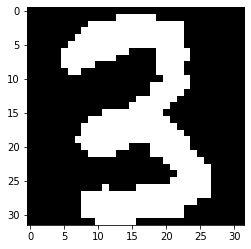

In [3]:
# Convert from original dataset
train_dataset = read_ori_data('data/optdigits-orig.tra')
data = get_data_with_label(train_dataset, 3)

# Display a sample of number 3
plt.imshow(data[0].reshape(32, -1), cmap='gray')
plt.show()

Do PCA with 2 components.

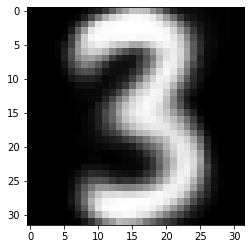

In [5]:
def PCA2(data):
    """PCA with 2 components
    return: Xm, V2, m
    """
    m = data.mean(axis=0, keepdims=True)
    X = (data - m).T 

    H = X.T @ X 
    w, U = torch.linalg.eig(H)
    w, U = w.clone().detach().float(), U.clone().detach().float()   # ComplexFloat to Float
    D = torch.diag(torch.sqrt(w))
    V = (torch.linalg.inv(U @ D) @ X.T).T

    V2 = V[:, :2]       # Select 2 principle components
    Xm = V2.T @ X

    return Xm, V2, m

# PCA 
Xm, V2, m = PCA2(data)

# Display eigen (mean) image
plt.imshow((V2 @ Xm + m.T)[:, 0].reshape(32, 32), cmap='gray')
plt.show()

Plot PCA results.

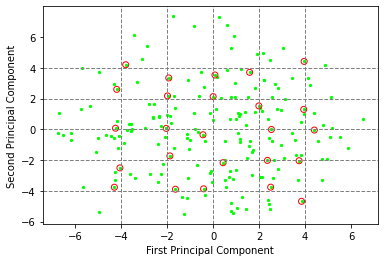

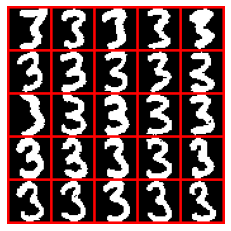

In [8]:
def get_focus(x, y, axv, axh):
    focus = []
    for v in axv:
        for h in axh:
            best = 0
            for i in range(int(list(x.size())[0])):
                if pow((x[i] - v), 2) + pow((y[i] - h), 2) < pow((x[best] - v), 2) + pow((y[best] - h), 2):
                    best = i
            focus.append(best)
    return focus

def vis_pca2(data, x, y, axv, axh, focus):
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')   
    for v in axv:
        plt.axvline(x=v,color="grey",ls="--",lw=1)
    for h in axh:
        plt.axhline(y=h,color="grey",ls="--",lw=1)
    # print(x, y)
    plt.scatter(x, y, color='lime', s=5)
    
    fx, fy = [x[i] for i in focus], [y[i] for i in focus]
    plt.scatter(fx, fy, color='none', marker='o', edgecolor='red')
    plt.show()

    padding = 2
    L = 32 * 5 + padding * 6
    canvas = np.zeros((L, L, 3))
    canvas[:, :, 0] = np.ones((L, L))

    for i in range(5):
        x = padding * (i + 1) + i * 32
        for j in range(5):
            y = padding * (j + 1) + j * 32
            img = data[focus[i * 5 + j]].reshape(32, 32)
            img = np.stack((img, img, img), axis=-1)
            canvas[x: x + 32, y: y + 32] = img
            
    plt.axis('off')
    plt.imshow(canvas)
    plt.show()

# Plot PCA result
axv = np.linspace(-4, 4, 5, endpoint=True)
axh = np.linspace(-4, 4, 5, endpoint=True)
focus = get_focus(Xm[0], Xm[1], axv, axh)
vis_pca2(data, Xm[0], Xm[1], axv, axh, focus)